## PKIS2 kinase-informed notebook
In this notebook, we create the workflow for the following model setting:

- Data set: PKIS2 which uses KinomeScan assays
- Molecular component type: ligand-based
- Ligand feature: Morgan fingerprint
- Kinase feature: scaled binding site composition
- Model Architecture: tree-based (using XGBoost)


We will consider the following metrics:
- Loss: MSE
- Goodness of fit: $R^2$

We will test different evaluation strategies: train-test split 
- [ ] Random (K fold)
- [ ] Time (K splits)
- [ ] Scaffold (K clusters)


### TODO
- [ ] In the API, when dealing with the XGBoost package, separate the notion of observation model and custom loss.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.simplefilter("ignore") 
import logging
logging.basicConfig(level=logging.ERROR)
import numpy as np

### Load PKIS2 data

In [4]:
from kinoml.datasets.kinomescan.pkis2 import PKIS2DatasetProvider

### First as a DatasetProvider

In [5]:
pkis2 = PKIS2DatasetProvider.from_source()

### Now as a pandas dataframe

In [6]:
df = pkis2.to_dataframe()
df

,Systems,n_components,PercentageDisplacementMeasurement
0,AAK1 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2...,2,14.0
1,ABL1-nonphosphorylated & Clc1cccc(Cn2c(nn3c2nc...,2,28.0
2,ABL1-nonphosphorylated & Clc1cccc(Cn2c(nn3c2nc...,2,20.0
3,ABL2 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2...,2,5.0
4,ACVR1 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C...,2,0.0
...,...,...,...
261865,ZAP70 & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)cc12)...,2,0.0
261866,p38-alpha & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)c...,2,0.0
261867,p38-beta & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)cc...,2,0.0
261868,p38-delta & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)c...,2,0.0


### A few statistics about this data

In [7]:
import matplotlib.pyplot as plt

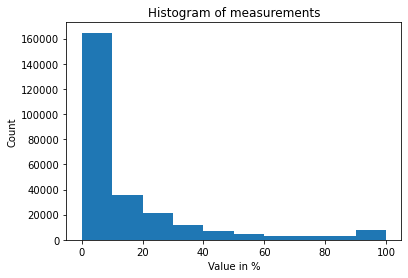

In [8]:
f = plt.figure
plt.hist(df['PercentageDisplacementMeasurement'])
plt.xlabel('Value in %')
plt.ylabel('Count')
plt.title('Histogram of measurements')
plt.show()

In [9]:
print("Measurements:", len(pkis2.measurements))
print("Systems:", len(pkis2.systems))
print("Ligands:",len(set([s.ligand for s in pkis2.systems])))
print("Proteins:", len(set([s.protein for s in pkis2.systems])))

Measurements: 261870
Systems: 257920
Ligands: 640
Proteins: 403


In [10]:
from collections import Counter
print('Number of zeros : ', Counter(df['PercentageDisplacementMeasurement'] == 0.0))

Number of zeros :  Counter({False: 139025, True: 122845})


### Featurize the ligand
We use the Morgan fingerprint and set the radius at 2, the vector length at 1024.

In [11]:
from kinoml.features.ligand import MorganFingerprintFeaturizer

In [12]:
morgan_featurizer = MorganFingerprintFeaturizer(nbits=1024, radius=2)

### Featurize the kinase

In [13]:
from kinoml.features.protein import AminoAcidCompositionFeaturizer
from kinoml.features.core import ScaleFeaturizer, Concatenated, Pipeline

In [14]:
composition_featurizer = Pipeline([AminoAcidCompositionFeaturizer(), ScaleFeaturizer()])

### Model input featurizers
For this model, we concatenate the ligand and kinase featurizers as to have one single vector as input for the considered model.

We then featurize all the systems in PKIS2. 

In [15]:
concat_featurizers = Concatenated([morgan_featurizer, composition_featurizer], axis=0)

In [16]:
pkis2.featurize(concat_featurizers)

### XGBoost package
We export the data to be compatible with the XGBoost libraray.

In [17]:
data = pkis2.to_xgboost()
data

### Objective function
The objective function is the function which is optimized in the algorithm. It is a custom loss function which depends on the observation model.

In [18]:
# TODO: to be implemented in the API
obj_function = pkis2.custom_loss_xgboost()
obj_function

AttributeError: 'PKIS2DatasetProvider' object has no attribute 'custom_loss_xgboost'

### Model Training

We define the tree-based model per say and train it.

In [19]:
import xgboost as xgb
params = {'learning_rate': 1.0}
model = xgb.train(dtrain=data, params=params, obj=obj_function)

NameError: name 'obj_function' is not defined

### Model evaluating
We evaluate the model on the data set, which gives us a prediction for $\Delta g$. Given the prediction, we then apply the observation model to obtain the predictions for the observed values. 


In [21]:
deltag_train = model.predict(data) # model predicts deltag
prediction = pkis2.observation_model(deltag_train) # apply observation model to predicted deltag

NameError: name 'model' is not defined

In [ ]:
true = data.get_label() # true, observed values

In [ ]:
r2 = r2_score(true, prediction)
print(f"R2: Goodness of fit measure: {r2:.2f}")

XGBoost with pIC50 Chembl Here:
https://github.com/openkinome/kinoml/blob/observation-model/examples/ChEMBL.ipynb

PKIS2 workflow here:
https://github.com/openkinome/kinoml/blob/api/examples/PKIS2.ipynb